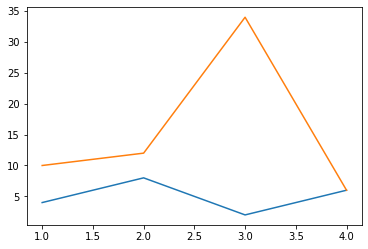

In [8]:
import matplotlib.pyplot as plt
import numpy as np
data_lst = np.array([1,2,3,4])
stock1 = np.array([4,8,2,6])
stock2 = np.array([10,12,34,6])

plt.plot(data_lst, stock1)
plt.plot(data_lst, stock2)
plt.show()

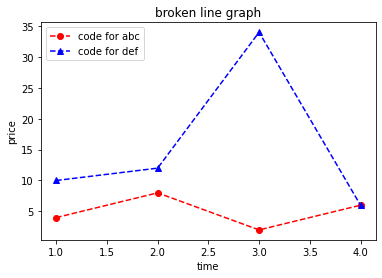

In [9]:
data_lst = [1,2,3,4]
stock1 = [4,8,2,6]
stock2 = [10,12,34,6]
plt.plot(data_lst, stock1, "ro--", label="code for abc")
plt.plot(data_lst, stock2, "b^--", label="code for def")
plt.title("broken line graph")
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.show()

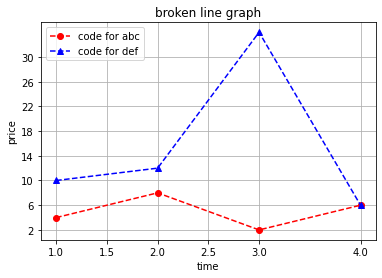

In [10]:
data_lst = [1,2,3,4]
stock1 = [4,8,2,6]
stock2 = [10,12,34,6]
plt.plot(data_lst, stock1, "ro--", label="code for abc")
plt.plot(data_lst, stock2, "b^--", label="code for def")
plt.title("broken line graph")
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.xticks([1,1.5,2,2.5,3,4])
plt.yticks(np.arange(2,34,4))
plt.grid()
plt.show()

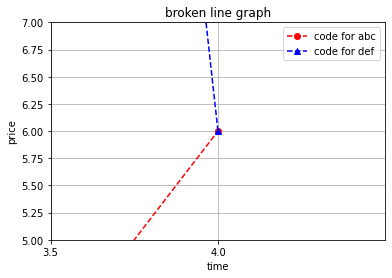

In [11]:

data_lst = [1,2,3,4]
stock1 = [4,8,2,6]
stock2 = [10,12,34,6]
plt.plot(data_lst, stock1, "ro--", label="code for abc")
plt.plot(data_lst, stock2, "b^--", label="code for def")
plt.legend()
plt.title("broken line graph")
plt.xlabel("time")
plt.ylabel("price")
plt.xticks([1,1.5,2,2.5,3,3.5,4])
#plt.yticks(np.arange(2,34,4))
plt.grid()

plt.xlim(3.5, 4.5)
plt.ylim(5,   7)


plt.show()

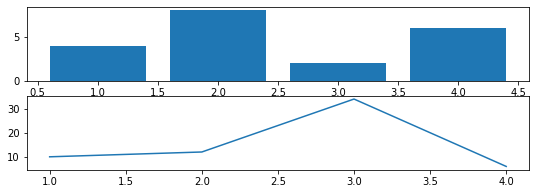

In [12]:
plt.figure(figsize=(9,3))
plt.subplot(211)
plt.bar(data_lst, stock1)
plt.subplot(212)
plt.plot(data_lst, stock2, "")


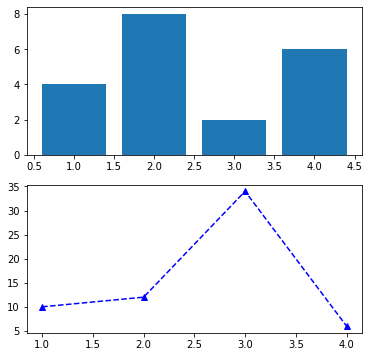

In [13]:
fig, axes = plt.subplots(2,1, figsize=(6,6))
axes[0].bar(data_lst, stock1)
axes[1].plot(data_lst, stock2, "b^--")

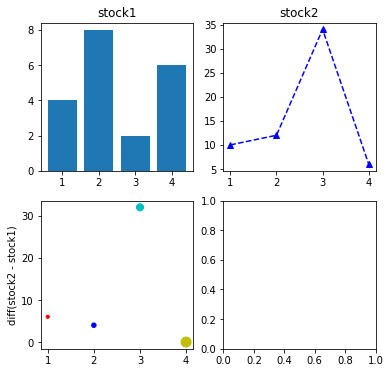

In [14]:
data_lst = np.array([1,2,3,4])
stock1 = np.array([4,8,2,6])
stock2 = np.array([10,12,34,6])
fig, axes = plt.subplots(2,2, figsize=(6,6))
axes[0, 0].bar(data_lst, stock1)
axes[0, 1].plot(data_lst, stock2, "b^--")
ax10 = axes[1, 0]
ax10.scatter(
    data_lst, stock2-stock1,
    s = [10, 20, 50, 100],
    c = ['r', 'b', 'c', 'y'],
    )
ax10.set_ylabel("diff(stock2 - stock1)")
axes[0,0].set_title("stock1")
axes[0,1].set_title("stock2")
plt.show()

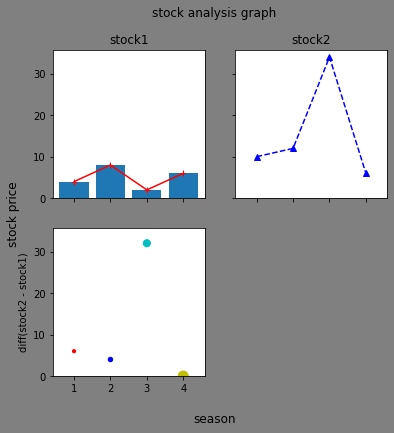

In [18]:
fig, axes = plt.subplots(
    2,2,figsize=(6,6),
    facecolor="grey",
    sharex=True, sharey=True
    )

axes[0, 0].bar(data_lst, stock1)
axes[0, 1].plot(data_lst, stock2, "b^--")
ax10 = axes[1, 0]
ax10.scatter(
    data_lst, stock2-stock1,
    s = [10, 20, 50, 100],
    c = ['r', 'b', 'c', 'y'],
    )
ax10.set_ylabel("diff(stock2 - stock1)")
axes[0,0].set_title("stock1")
axes[0,1].set_title("stock2")

axes[1,1].remove()
axes[0,0].plot(data_lst, stock1, "r+-")

fig.suptitle("stock analysis graph")
fig.supylabel("stock price")
fig.supxlabel("season")
plt.show()

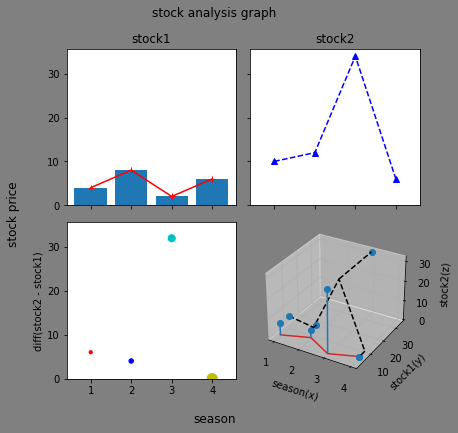

In [30]:
data_lst = np.array([1,2,3,4])
stock1 = np.array([4,8,2,6])
stock2 = np.array([10,12,34,6])
fig, axes = plt.subplots(
    2,2,figsize=(6,6),
    facecolor="grey",
    sharex=True, sharey=True
    )
axes[0, 0].bar(data_lst, stock1)
axes[0, 1].plot(data_lst, stock2, "b^--")
ax10 = axes[1, 0]
ax10.scatter(
    data_lst, stock2-stock1,
    s = [10, 20, 50, 100],
    c = ['r', 'b', 'c', 'y'],
    )
ax10.set_ylabel("diff(stock2 - stock1)")
axes[0,0].set_title("stock1")
axes[0,1].set_title("stock2")


axes[1,1].remove()
axes[0,0].plot(data_lst, stock1, "r+-")

fig.suptitle("stock analysis graph")
fig.supylabel("stock price")
fig.supxlabel("season")


ax11 = fig.add_subplot(224, projection='3d', facecolor="grey")
ax11.stem(data_lst, stock1, stock2-stock1)
ax11.stem(
    data_lst, stock2, stock2-stock1,
    linefmt='k--', basefmt='k--',
    bottom=10, orientation='y'
    )
ax11.set_xlabel("season(x)")
ax11.set_ylabel("stock1(y)")
ax11.set_zlabel("stock2(z)")

fig.suptitle("stock analysis graph")
fig.supylabel("stock price")
fig.supxlabel("season")
plt.tight_layout()
plt.show()

In [37]:

import matplotlib.pyplot as plt
from matplotlib import font_manager
 
for font in font_manager.fontManager.ttflist:
    # 查看字体名以及对应的字体文件名
    print(font.name, '-', font.fname)

cmr10 - /public/home/mayuan/miniconda3/envs/cage/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf
DejaVu Serif - /public/home/mayuan/miniconda3/envs/cage/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf
cmtt10 - /public/home/mayuan/miniconda3/envs/cage/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf
STIXGeneral - /public/home/mayuan/miniconda3/envs/cage/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf
cmsy10 - /public/home/mayuan/miniconda3/envs/cage/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf
DejaVu Sans Mono - /public/home/mayuan/miniconda3/envs/cage/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf
DejaVu Serif - /public/home/mayuan/miniconda3/envs/cage/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf
DejaVu Sans - /public/home/mayuan/miniconda3/envs/cage/lib/python3.9/site-packages/matplotlib/mpl

In [66]:
from mendeleev import element
H = element("H")
print(H.atomic_radius)
print(H.atomic_radius_rahm)
print(H.covalent_radius)
print(H.covalent_radius_bragg)
print(H.covalent_radius_cordero)


25.0
154.0
32.0
None
31.0


In [20]:
import numpy as np
from itertools import combinations
from pyxtal.tolerance import Tol_matrix
dist = np.array( [[2.645,   2.24825,            1.9044],
                 [2.24825, 1.8515000000000001, 1.5076500000000002],
                 [1.9044,  1.5076500000000002, 1.1638000000000002]])
nameofatoms = ["Ca", "Mg", "H"]
tm = Tol_matrix(prototype="atomic")

In [21]:
species_radium = list(zip(nameofatoms ,np.diagonal(dist)/2))
species_radium

[('Ca', 1.3225), ('Mg', 0.9257500000000001), ('H', 0.5819000000000001)]

In [27]:
for ele_R1, ele_R2 in combinations(species_radium, 2):
    print(ele_R1, ele_R2)
    tm.set_tol(ele_R1[0], ele_R2[0], ele_R1[1]+ele_R2[1])
    print(tm.get_tol(ele_R1[0], ele_R2[0]))

('Ca', 1.3225) ('Mg', 0.9257500000000001)
2.24825
('Ca', 1.3225) ('H', 0.5819000000000001)
1.9044
('Mg', 0.9257500000000001) ('H', 0.5819000000000001)
1.5076500000000002


In [43]:
Lu = 2.800 * 0.53
Be = 2.800 * 0.53
H  = 1.1 * 0.53

In [44]:
l = [Lu, Be, H]
print(l)
import numpy as np
l = np.array(l)
res =[]
for i in l:
    print(i)
    x = i + l
    res.append(x)


[1.484, 1.484, 0.5830000000000001]
1.484
1.484
0.5830000000000001


In [2]:
import sys
from pathlib import Path
from pprint import pprint

import pandas as pd
from pymatgen.analysis.phase_diagram import PDEntry, PhaseDiagram, PDPlotter
from pymatgen.core.composition import Composition

/public/home/mayuan/miniconda3/envs/cage/lib/python3.9/site-packages/pymatgen/analysis/phase_diagram.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
input_csv_path = Path("./B-H.csv")
convexhull_data = pd.read_csv(input_csv_path, header=0, sep=',')
ini_entries = []
for idx, row in convexhull_data.iterrows():
    comp = Composition(row['formula'])
    enth = row['enthalpy']
    entry_id = row['Number']
    _entry = PDEntry(comp, enth)
    _entry.entry_id = entry_id
    ini_entries.append(_entry)
ini_pd = PhaseDiagram(ini_entries)

In [22]:
for ent in ini_pd.stable_entries:
    print(ent.entry_id)

3
2
414
393
436
368
441
108
293
307


In [12]:
stable_formulas = [[ent.name, ent.] for ent in ini_pd.stable_entries]
stable_formulas

['H2', 'B', 'BH20', 'B3H5', 'BH19', 'B5H2', 'B2H', 'BH', 'B6H', 'B2H19']

In [10]:
for e in ini_entries:
    ehull = ini_pd.get_e_above_hull(e)
    print (e.composition, ehull)

B3 H8 0.01618499922630561
B4 H9 0.039944389918166935
B6 H7 0.01266134076923077
B4 H9 0.0399592906873977
B5 H3 0.04822364833333333
B3 H11 0.04557240664133739
B2 H19 0.0024599390476190484
B4 H9 0.035322196841243866
B4 H10 0.019546421626139815
B5 H19 0.006608412118794327
B5 H12 0.025215857884856068
B4 H2 0.07579216666666666
B4 H3 0.09726729690476191
B5 H15 0.002639608776595745
B3 H6 0.01690343598108747
B6 H9 0.011479883333333331
B3 H11 0.015965562355623103
B4 H19 0.024278896401480107
B3 H8 0.01618499922630561
B4 H9 0.039944389918166935
B6 H7 0.01266134076923077
B4 H9 0.0399592906873977
B5 H3 0.04822364833333333
B3 H11 0.04557240664133739
B2 H19 0.0024599390476190484
B4 H9 0.035322196841243866
B4 H10 0.019546421626139815
B5 H19 0.006608412118794327
B5 H12 0.025215857884856068
B4 H2 0.07579216666666666
B4 H3 0.09726729690476191
B5 H15 0.002639608776595745
B3 H6 0.01690343598108747
B6 H9 0.011479883333333331
B3 H11 0.015965562355623103
B4 H19 0.024278896401480107
B2 H13 0.0069381931347517745